# Boosting and Stacking Exercises

![Boosting.png](Assets/Boosting.png)

# Learning Objectives

- Explain how the boosting algorithm helps reduce variance and bias.
- Apply Intel® Extension for Scikit-learn* to leverage underlying compute capabilities of hardware

# scikit-learn* 

Frameworks provide structure that Data Scientists use to build code. Frameworks are more than just libraries, because in addition to callable code, frameworks influence how code is written. 

A main virtue of using an optimized framework is that code runs faster. Code that runs faster is just generally more convenient but when we begin looking at applied data science and AI models, we can see more material benefits. Here you will see how optimization, particularly hyperparameter optimization can benefit more than just speed. 

These exercises will demonstrate how to apply **the Intel® Extension for Scikit-learn*,** a seamless way to speed up your Scikit-learn application. The acceleration is achieved through the use of the Intel® oneAPI Data Analytics Library (oneDAL). Patching is the term used to extend scikit-learn with Intel optimizations and makes it a well-suited machine learning framework for dealing with real-life problems. 

To get optimized versions of many Scikit-learn algorithms using a patch() approach consisting of adding these lines of code PRIOR to importing sklearn: 

- **from sklearnex import patch_sklearn**
- **patch_sklearn()**

## This exercise relies on installation of  Intel® Extension for Scikit-learn*

If you have not already done so, follow the instructions from Week 1 for instructions

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website above.

In [1]:
from __future__ import print_function
import os
data_path = [ 'data']

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import VotingClassifier


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Question 1

* Import the data from the file `Human_Activity_Recognition_Using_Smartphones_Data.csv` and examine the shape and data types. For the data types, there will be too many to list each column separately. Rather, aggregate the types by count.
* Determine if the float columns need to be scaled.

In [2]:
import pandas as pd
import numpy as np

filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data has quite a few predictor columns.

In [3]:
data.shape

(10299, 562)

And they're all float values. The only non-float is the categories column, which is what's being predicted.

In [4]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

The minimum and maximum value for the float columns is -1.0 and 1.0, respectively. However, scaling is never required for tree-based methods.

In [5]:
# Mask to select float columns
float_columns = (data.dtypes == float)

# Verify that the maximum of all float columns is 1.0
print( (data.loc[:,float_columns].max()==1.0).all() )

# Verify that the minimum of all float columns is -1.0
print( (data.loc[:,float_columns].min()==-1.0).all() )

True
True


## Question 2

* Integer encode the activities.
* Split the data into train and test data sets. Decide if the data will be stratified or not during the train/test split.

In [6]:
le = LabelEncoder()

data['Activity'] = le.fit_transform(data['Activity'])

le.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [7]:
data.Activity.unique()

array([2, 1, 0, 3, 4, 5])

**NOTE**: We are about to create training and test sets from `data`. On those datasets, we are going to run grid searches over many choices of parameters. This can take some time. In order to shorten the grid search time, feel free to downsample `data` and create `X_train, X_test, y_train, y_test` from the downsampled dataset.

Now split the data into train and test data sets. A stratified split was not used here. If there are issues with any of the error metrics on the test set, it can be a good idea to start model fitting over using a stratified split. Boosting is a pretty powerful model, though, so it may not be necessary in this case.

In [8]:
# Alternatively, we could stratify the categories in the split, as was done previously
feature_columns = [x for x in data.columns if x != 'Activity']

X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data['Activity'],
                 test_size=0.3, random_state=42)


In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7209, 561), (7209,), (3090, 561), (3090,))

## Question 3

* Fit gradient boosted tree models with all parameters set to their defaults the following tree numbers (`n_estimators = [25, 50, 100, 200, 400]`) and evaluate the accuracy on the test data for each of these models. 
* Plot the accuracy as a function of estimator number.

**Note:** This question may take some time to execute, depending on how many different values are fit for estimators. Setting `max_features=4` in the gradient boosting classifier will increase the convergence rate.

Also, this is similar to question 3 from week 9, except that there is no such thing as out-of-bag error for boosted models. And the `warm_flag=True` setting has a bug in the gradient boosted model, so don't use it. Simply create the model inside the `for` loop and set the number of estimators at this time. This will make the fitting take a little longer. Additionally, boosting models tend to take longer to fit than bagged ones because the decision stumps must be fit successively.

In [10]:
error_list = list()

# Iterate through all of the possibilities for number of estimators
tree_list = [15, 50, 100, 200, 400]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, 
                                     subsample=0.5,
                                     max_features=4,
                                     random_state=42)

    # Fit the model
    GBC.fit(X_train.values, y_train.values)
    y_pred = GBC.predict(X_test)

    # Get the error
    error = 1. - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

,error
n_trees,
15.0,0.106472
50.0,0.044984
100.0,0.027832
200.0,0.019417
400.0,0.014563


Now plot the result.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

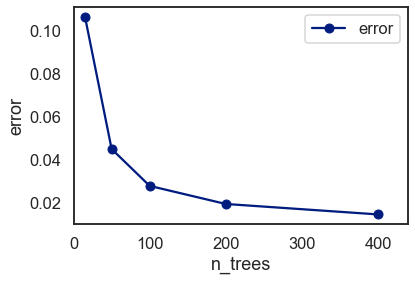

In [12]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

# Create the plot
ax = error_df.plot(marker='o')

# Set parameters
ax.set(xlabel='n_trees', ylabel='error')
ax.set_xlim(0, max(error_df.index)*1.1);

## Question 4

* Using a grid search with cross-validation, fit a new gradient boosted classifier with the a list of estimators, similar to question 3. Also consider  varying the learning rates (0.1, 0.01, 0.001, etc.), the subsampling value (1.0 or 0.5), and the number of maximum features (1, 2, etc.).
* Examine the parameters of the best fit model.
* Calculate relevant error metrics on this model and examine the confusion matrix.

**Note:** this question may take some time to execute, depending on how many features are associated with the grid search. It is recommended to start with only a few to ensure everything is working correctly and then add more features. Setting `max_features=4` in the gradient boosting classifier will increase the convergence rate.

In [13]:
# The parameters to be fit--only n_estimators and learning rate
# have been varied here for simplicity
param_grid = {'n_estimators': [200, 400],
              'learning_rate': [0.1, 0.01]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(subsample=0.5,
                                                 max_features=4,
                                                 random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In [14]:
# The best model
GV_GBC.best_estimator_

GradientBoostingClassifier(max_features=4, n_estimators=400, random_state=42,
                           subsample=0.5)

The error metrics. Classification report is particularly convenient for multi-class cases.

In [15]:
y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.96      0.97      0.97       554
           2       0.97      0.96      0.97       554
           3       1.00      1.00      1.00       540
           4       0.99      1.00      1.00       418
           5       1.00      0.99      0.99       427

    accuracy                           0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090



The confusion matrix. Note that the gradient boosted model has a little trouble distinguishing between activity class 1 and 2.

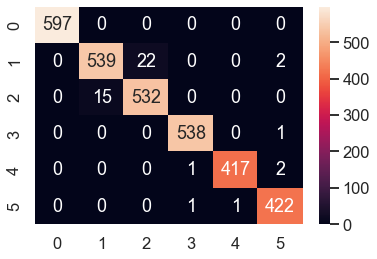

In [16]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

## Question 5

* Create an AdaBoost model and fit it using grid search, much like question 4. Try a range of estimators between 100 and 200.
* Compare the errors from AdaBoost to those from the GradientBoostedClassifier.

**NOTE:** Setting `max_features=4` in the decision tree classifier used as the base classifier for AdaBoost will increase the convergence rate.

In [17]:
ABC = AdaBoostClassifier(DecisionTreeClassifier(max_features=4))

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train, y_train)

The best model.

In [18]:
# The best model
GV_ABC.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_features=4),
                   learning_rate=0.001, n_estimators=100)

The error metrics. Note that the issues with class 1 and 2 appear to have become more problematic and now include class 0. Also note other issues for classes 3 - 5. AdaBoost is very sensitive to outliers, so that could be the problem here.

In [19]:
y_pred = GV_ABC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       598
           1       0.61      0.63      0.62       547
           2       0.69      0.67      0.68       560
           3       0.88      0.88      0.88       535
           4       0.84      0.83      0.84       424
           5       0.83      0.82      0.82       426

    accuracy                           0.76      3090
   macro avg       0.77      0.77      0.77      3090
weighted avg       0.76      0.76      0.76      3090



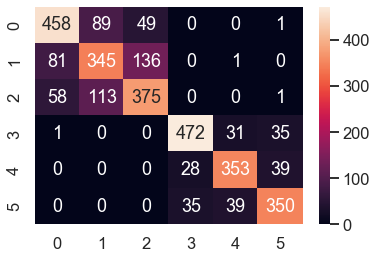

In [20]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

## Question 6

* Fit a logistic regression model with regularization. This can be a replica of a model that worked well in the exercises from week 4.
* Using `VotingClassifier`, fit the logistic regression model along with either the GratientBoostedClassifier or the AdaBoost model (or both) from questions 4 and 5.
* Determine the error as before and compare the results to the appropriate gradient boosted model(s).
* Plot the confusion matrix for the best model created in this set of exercises.

In [21]:
# L2 regularized logistic regression
LR_L2 = LogisticRegressionCV(max_iter=295, Cs=1, cv=4, penalty='l2').fit(X_train, y_train)

Check the errors and confusion matrix for the logistic regression model.

In [22]:
y_pred = LR_L2.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       632
           1       0.41      0.98      0.57       234
           2       0.99      0.65      0.78       836
           3       0.93      0.88      0.91       569
           4       0.78      0.95      0.86       347
           5       0.92      0.83      0.87       472

    accuracy                           0.84      3090
   macro avg       0.84      0.87      0.83      3090
weighted avg       0.90      0.84      0.85      3090



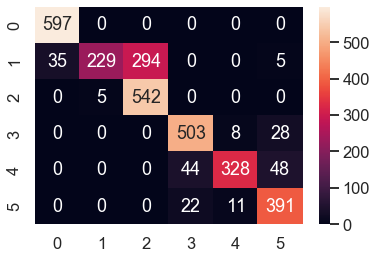

In [23]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

And now the stacked model.

In [24]:
# The combined model--logistic regression and gradient boosted trees
estimators = [('LR_L2', LR_L2), ('GBC', GV_GBC)]

# Though it wasn't done here, it is often desirable to train 
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

Finally the error on the voting classifier. We do a little better here than with either logistic regression or gradient boosted trees alone. However, the fact that logistic regression does almost as well as gradient boosted trees is an important reminder that it's good practice to try the simplest model first. In some cases, its performance will be good enough.

In [25]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.97      0.95      0.96       563
           2       0.96      0.97      0.97       547
           3       1.00      1.00      1.00       539
           4       1.00      0.99      0.99       420
           5       0.98      1.00      0.99       424

    accuracy                           0.98      3090
   macro avg       0.98      0.99      0.98      3090
weighted avg       0.98      0.98      0.98      3090



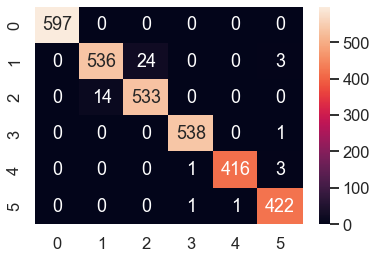

In [26]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')